# Фадеев Иван Имитационное моделирование КР

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize': (13, 7)})

<font size="3"><b>Для примера модели хищник – жертва, рассмотренного выше,
требуется подобрать сезоны охоты на волков, чтобы популяция кроликов и волков стабилизировалась в окрестности некоторого значения
и амплитуда колебаний численности популяции не превышала $10\%$.
Во время сезона охоты популяция волков дополнительно уменьшается на $0.6*N_2$ за единицу времени.<br>


### Модель хищник – жертва

<font size="3"><b>Пусть $N_1$ популяция кроликов, $N_2$ популяция волков, $r_1, r_2, s_1, s_2$ коэффициенты рождаемости и смертности кроликов и волков соответственно, 
тогда модель между их взаимодействиями можно описать следующими уравнениями:

$$\begin{cases}
   \frac{\delta N_1}{\delta t}=\dot{N_1} = r_1 \cdot N_1 - s_1 \cdot N_1\cdot N_2\\
   \frac{\delta N_2}{\delta t} = \dot{N_2} =  r_2 \cdot N_1\cdot N_2 - s_2 \cdot N_2\\
\end{cases}$$

In [2]:
def derivative_N1(N2,N1):
    if N1>2: return r1*N1-s1*N1*N2
    return -s1*N1*N2

def derivative_N2(N1,N2):
    if N2>2: return r2*N1*N2-s2*N2
    return -s2*N2

def derivative_N2_with_hunt(N1,N2):
    der_N2 = -s2*N2
    if N2>2: der_N2 += r2*N1*N2
    if N2>huntLimit: der_N2 -= 0.6*N2
    return der_N2

<center><font size="3"><b>Метод Рунге — Кутты четвёртого порядка вычислению значения функции $y(x)$ в точке $x+h$

$$\dot{y}=y^{'}=\frac{\delta y}{\delta x} = f(x,y)$$

$$y(x+h)\approx y(x)+\frac{h}{6}(k_1+2k_2+2k_3+k_4)$$</front>

<center><font size="4"><b>Где:</front>
<font size="3">
$$k_1 = f(x,y)$$
$$k_2 = f(x+\frac{h}{2}, y+\frac{h}{2}k_1)$$
$$k_3 = f(x+\frac{h}{2}, y+\frac{h}{2}k_2)$$
$$k_4 = f(x+h, y+h \ k_3)$$



In [3]:
def runge_kutta(f, x, y, h=0.01):
    k1 = h * f(x, y)
    k2 = h * f(x + h/2, y + h*k1/2)
    k3 = h * f(x + h/2, y + h*k2/2)
    k4 = h * f(x + h, y + h*k3)
    return y + h * (k1 + 2*k2 + 2*k3 + k4) / 6

<center><font size="3"><b>Напишем функцию, которая будет моделировать изменение популяции в течение времени

In [4]:
def modulate_one_turn(N1, N2, withHunt):
    N1 = runge_kutta(derivative_N1, N2, N1, dt)
    if withHunt: N2 = runge_kutta(derivative_N2_with_hunt, N1, N2, dt)
    else: N2 = runge_kutta(derivative_N2, N1, N2, dt)
    return N1, N2

def modulate_time(N1,N2, time=100_000, withHunt=False):
    data = np.array([[N1,N2]])
    for i in range(time):
        N1, N2 = modulate_one_turn(N1,N2, withHunt)
        
        data = np.vstack([data,[N1,N2]])
    return data

<center><font size="3"><b>Моделируем не учитывая сезон охоты на волков

In [30]:
r1 = 4
r2 = 0.004
s1 = 0.02
s2 = 0.8

dt = 0.02

N1 = 1000
N2 = 100

time = 50_000

data = modulate_time(N1,N2, time, withHunt=False)

In [31]:
max= data.max(axis=0)
min = data.min(axis=0)

print("Амплитуды колебаний популяции составили:", max-min)

Амплитуды колебаний популяции составили: [1233.17519142  481.02157358]


<Axes: >

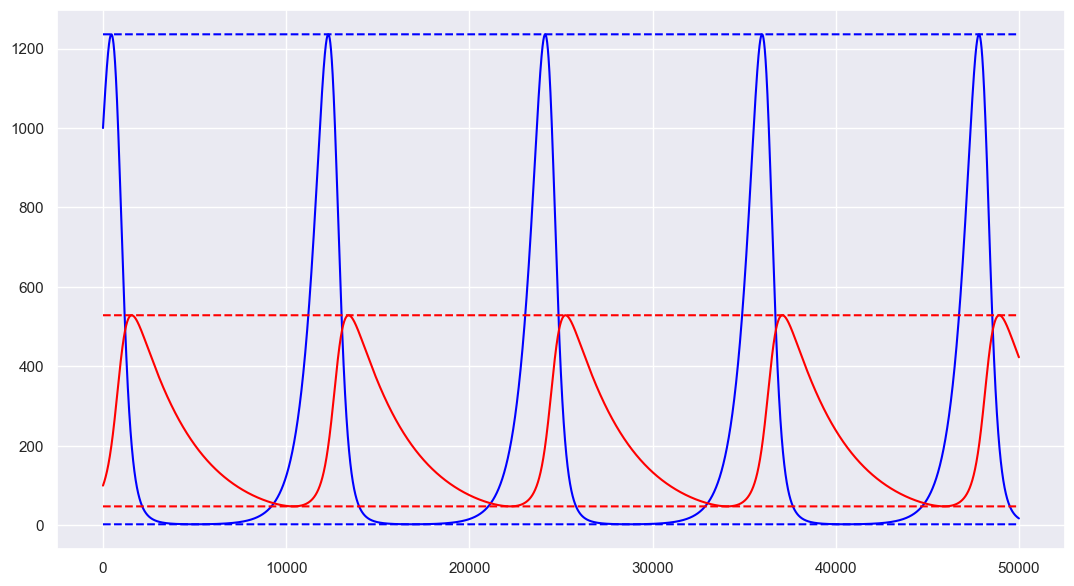

In [32]:
arange_x = np.arange(time)

sns.lineplot(data=data.T[0], color='blue')
sns.lineplot(x=arange_x, y=min[0], linestyle='dashed', color='blue')
sns.lineplot(x=arange_x, y=max[0], linestyle='dashed', color='blue')

sns.lineplot(data=data.T[1], color='red')
sns.lineplot(x=arange_x, y=min[1], linestyle='dashed', color='red')
sns.lineplot(x=arange_x, y=max[1], linestyle='dashed', color='red')

<Axes: >

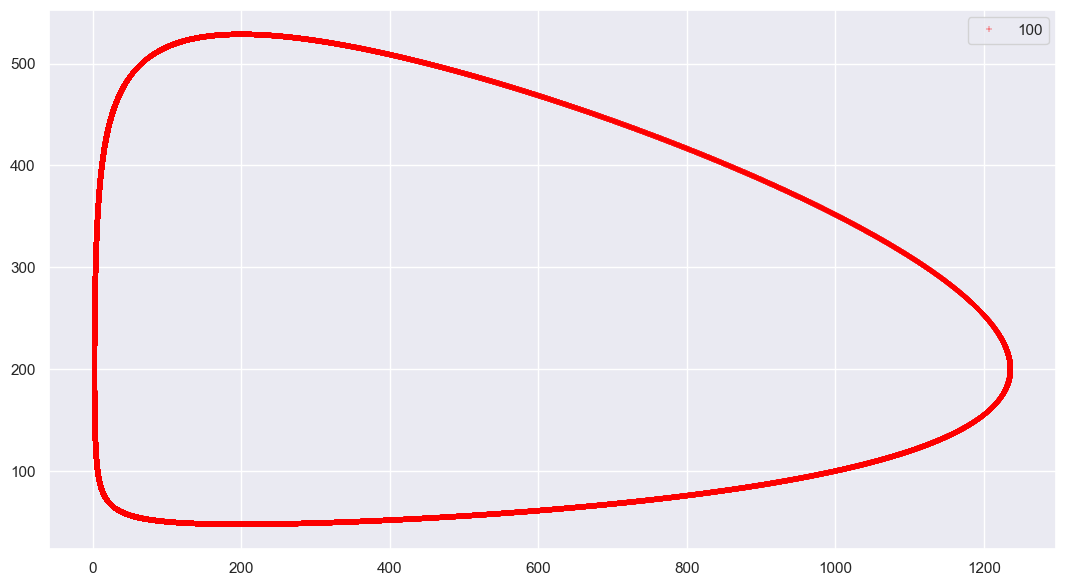

In [52]:
sns.scatterplot(x =data.T[0], y= data.T[1],size=100, color="red", marker="+")

<center><font size="2">Амплитуда колебаний популяции кроликов составила 1233, а волков 481<br>

<center><font size="3"><b>Теперь моделируем учитывая сезон охоты на волков<br>

<center>Объявляем сезон охоты открытым когда волков становится больше определенного количества

<center>Если нам нужна маленькая амплитуда колебаний, нам необходимо чтобы скорость изменения популяции была по модулю как можно меньше, попробуем найти такие $N_2$ при которых скорость изменения популяции $\dot{N_1}$ будет равна нулю

$$\begin{equation*}
 \dot{N_1} = r1\cdot N_1 -s_1 \cdot N_1 \cdot N_2 = 0 \rightarrow 
 \left[
 \begin{array}{cc}
   N_1 =0 \\
   N_2 = \frac{r1}{s1} = \frac{4}{0.02} = 200 \\
 \end{array}
 \right.
\end{equation*}$$

<center>При $N_2$ = 200 скорость изменения популяции волков $\dot{N_2}$ также равна 0,<br>
    система приходит в динамическое равновесие, зададим порог популяции волков на сезон охоты равным 200

In [53]:
huntLimit = 200
data = modulate_time(N1,N2, time, withHunt=True)

In [54]:
max= data[40_000:].max(axis=0)
min = data[40_000:].min(axis=0)

print("Амплитуды колебаний популяции составили:", max-min)

Амплитуды колебаний популяции составили: [0.02171931 0.02342661]


<Axes: >

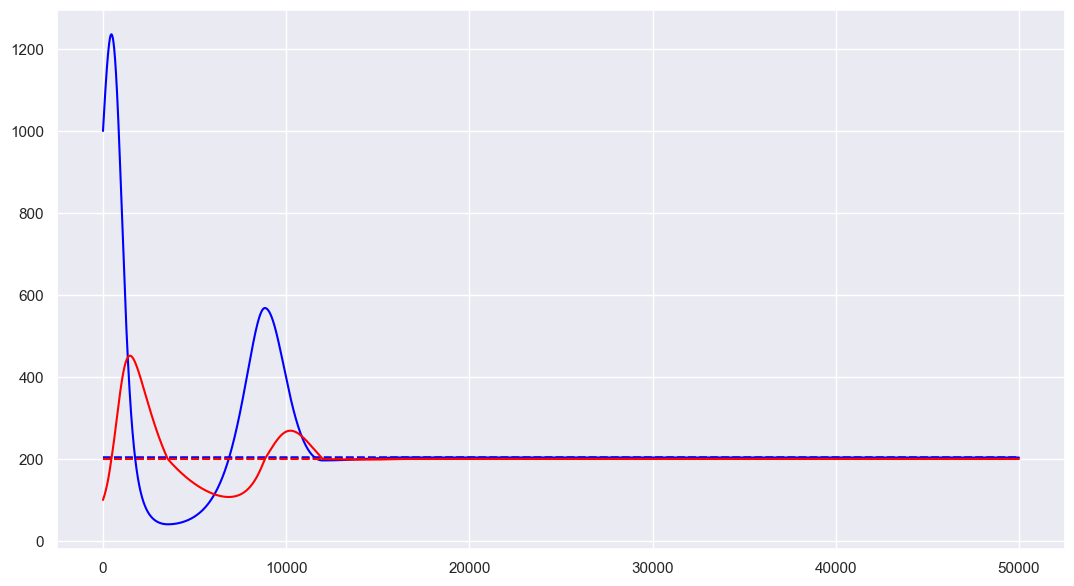

In [55]:
arange_x = np.arange(time)

sns.lineplot(data=data.T[0], color='blue')
sns.lineplot(x=arange_x, y=min[0], linestyle='dashed', color='blue')
sns.lineplot(x=arange_x, y=max[0], linestyle='dashed', color='blue')

sns.lineplot(data=data.T[1], color='red')
sns.lineplot(x=arange_x, y=min[1], linestyle='dashed', color='red')
sns.lineplot(x=arange_x, y=max[1], linestyle='dashed', color='red')

<Axes: >

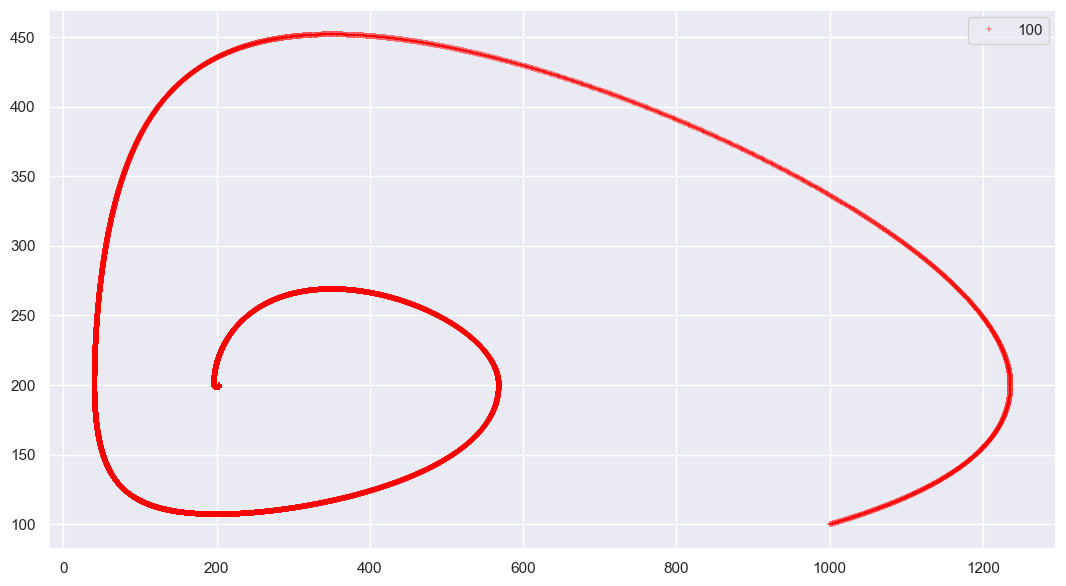

In [56]:
sns.scatterplot(x =data.T[0], y= data.T[1],size=100, color="red", marker="+")

<center>При пороге близким к 200 система также имеет очень низкую амплитуду колебаний, вот пример где амплитуда колебаний близка к 10% от первоночальной:

In [57]:
huntLimit = 180
data = modulate_time(N1,N2, time, withHunt=True)

In [58]:
max= data[40_000:].max(axis=0)
min = data[40_000:].min(axis=0)

print("Амплитуды колебаний популяции составили:", max-min)

Амплитуды колебаний популяции составили: [122.51811291  41.39538037]


<Axes: >

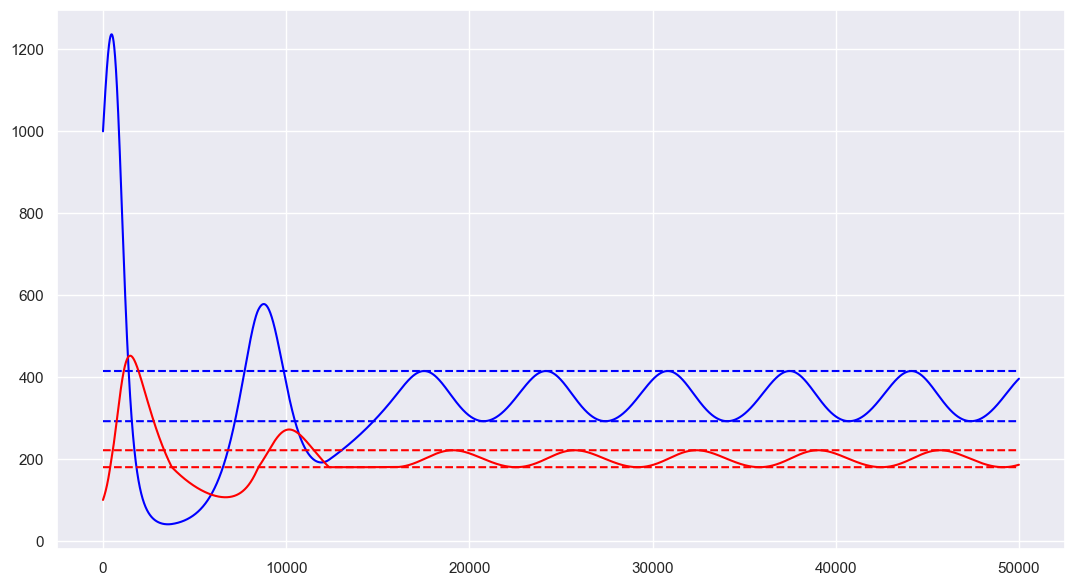

In [59]:
arange_x = np.arange(time)

sns.lineplot(data=data.T[0], color='blue')
sns.lineplot(x=arange_x, y=min[0], linestyle='dashed', color='blue')
sns.lineplot(x=arange_x, y=max[0], linestyle='dashed', color='blue')

sns.lineplot(data=data.T[1], color='red')
sns.lineplot(x=arange_x, y=min[1], linestyle='dashed', color='red')
sns.lineplot(x=arange_x, y=max[1], linestyle='dashed', color='red')

<Axes: >

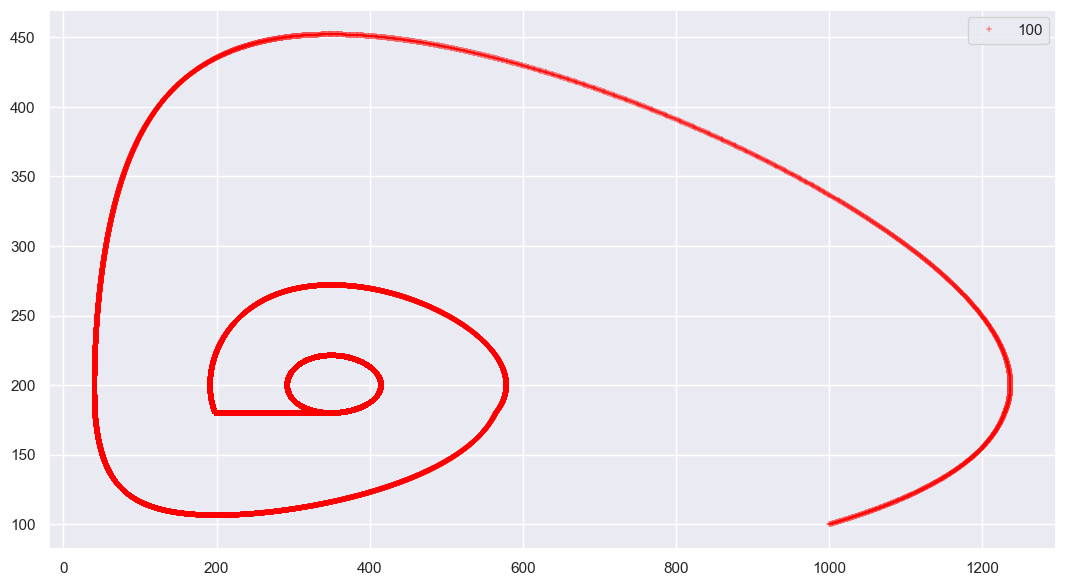

In [64]:
sns.scatterplot(x =data.T[0], y= data.T[1],size=100, color="red", marker="+")

In [ ]:
#create multyly matrix 9X9